In [2]:
%%time

from datetime import datetime, timedelta, timezone
import json
import os
import re
import boto3
from time import sleep
from threading import Thread

import pandas as pd

from sagemaker import get_execution_role, session, Session, image_uris
from sagemaker.s3 import S3Downloader, S3Uploader
from sagemaker.processing import ProcessingJob
from sagemaker.serializers import CSVSerializer

from sagemaker.model import Model
from sagemaker.model_monitor import DataCaptureConfig

session = Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
CPU times: user 1.27 s, sys: 362 ms, total: 1.63 s
Wall time: 2.72 s


In [3]:
# Get Execution role
role = get_execution_role()
print("RoleArn:", role)

region = session.boto_region_name
print("Region:", region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
RoleArn: arn:aws:iam::911199926915:role/LabRole
Region: us-east-1


In [4]:
# Setup S3 bucket
# You can use a different bucket, but make sure the role you chose for this notebook
# has the s3:PutObject permissions. This is the bucket into which the data is captured
bucket = session.default_bucket()
print("Bucket:", bucket)
prefix = "Smart_Grid/model_depolyment"

##S3 prefixes
data_capture_prefix = f"{prefix}/datacapture"
s3_capture_upload_path = f"s3://{bucket}/{data_capture_prefix}"

ground_truth_upload_path = (
    f"s3://{bucket}/{prefix}/ground_truth_data/{datetime.now():%Y-%m-%d-%H-%M-%S}"
)

reports_prefix = f"{prefix}/reports"
s3_report_path = f"s3://{bucket}/{reports_prefix}"

##Get the model monitor image
monitor_image_uri = image_uris.retrieve(framework="model-monitor", region=region)

print("Image URI:", monitor_image_uri)
print(f"Capture path: {s3_capture_upload_path}")
print(f"Ground truth path: {ground_truth_upload_path}")
print(f"Report path: {s3_report_path}")

Bucket: sagemaker-us-east-1-911199926915
Image URI: 156813124566.dkr.ecr.us-east-1.amazonaws.com/sagemaker-model-monitor-analyzer
Capture path: s3://sagemaker-us-east-1-911199926915/Smart_Grid/model_depolyment/datacapture
Ground truth path: s3://sagemaker-us-east-1-911199926915/Smart_Grid/model_depolyment/ground_truth_data/2024-02-15-19-08-52
Report path: s3://sagemaker-us-east-1-911199926915/Smart_Grid/model_depolyment/reports


In [5]:
train_model_id, train_model_version, train_scope = "lightgbm-regression-model", "*", "training"
inference_instance_type = "ml.m5.large"
# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)

Using model 'lightgbm-regression-model' with wildcard version identifier '*'. You can pin to version '2.1.0' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


In [6]:
model_name = f"smart-grid-LGBM-pred-model-monitor-{datetime.utcnow():%Y-%m-%d-%H%M}"

model_url = "s3://sagemaker-us-east-1-911199926915/Smart-Grid-prediction-lightGBM/output/LGBM-2024-02-04-19-49-05/SmartGrid-lightgbm-r-240204-1951-003-2a579e3d/output/model.tar.gz"

model = Model(image_uri=deploy_image_uri, model_data=model_url, role=role, sagemaker_session=session)

In [7]:
endpoint_name = f"smart-grid-LGBM-pred-model-quality-monitor-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("EndpointName =", endpoint_name)

data_capture_config = DataCaptureConfig(
    enable_capture=True, sampling_percentage=100, destination_s3_uri=s3_capture_upload_path
)

model.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    endpoint_name=endpoint_name,
    data_capture_config=data_capture_config,
)

EndpointName = smart-grid-LGBM-pred-model-quality-monitor-2024-02-15-1909
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
------!

In [14]:
from sagemaker.predictor import Predictor

predictor = Predictor(
    endpoint_name=endpoint_name, sagemaker_session=session, serializer=CSVSerializer()
)

In [9]:
validate_dataset = "validation_with_predictions.csv"

In [16]:
limit = 200  # Need at least 200 samples to compute standard deviations
i = 0
import json
with open(f"test_data/{validate_dataset}", "w") as baseline_file:
    baseline_file.write("prediction,label\n")  # our header
    with open("test_data/validation_data.csv", "r") as f:
        for row in f:
            (label, input_cols) = row.split(",", 1)
            prediction = predictor.predict(input_cols)
            data = json.loads(prediction)
            prediction_number = data['prediction'][0]
            baseline_file.write(f"{prediction_number},{label}\n")
            i += 1
            if i > limit:
                break
            print(".", end="", flush=True)
            sleep(0.5)
print()
print("Done!")

........................................................................................................................................................................................................
Done!


In [17]:
!head test_data/validation_with_predictions.csv

prediction,label
0.18991390837120498,0.259011
0.1619517934704773,0.22785021
0.14121530713917715,0.1908404
0.1296991125220355,0.1580797
0.1296991125220355,0.14016196
0.13292900111286904,0.1313667
0.1574929179869918,0.13451737
0.18926231079185496,0.14440958
0.22436757101117083,0.16721123


In [18]:
test_data = pd.read_csv("test_data/validation_with_predictions.csv")#,  header=None)
test_data

,prediction,label
0,0.189914,0.259011
1,0.161952,0.227850
2,0.141215,0.190840
3,0.129699,0.158080
4,0.129699,0.140162
...,...,...
196,0.118205,0.116447
197,0.127083,0.118868
198,0.156833,0.133747
199,0.190007,0.186571


In [19]:
!pip install -q matplotlib


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


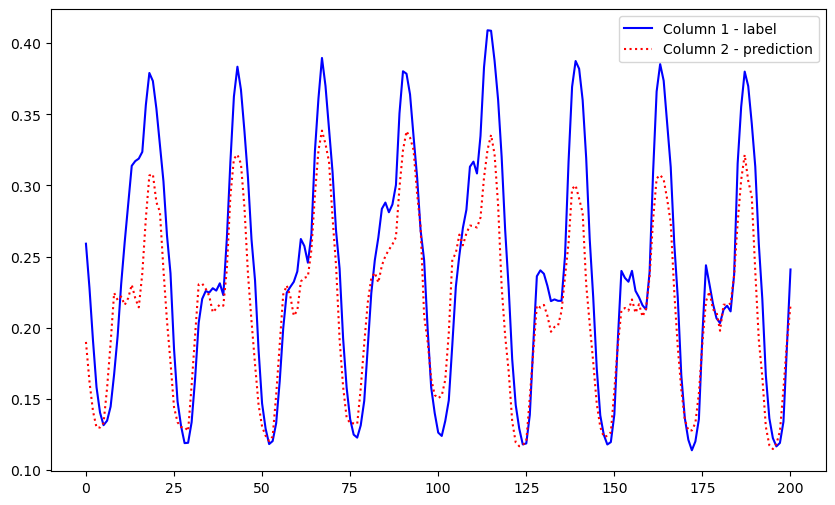

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Plotting the first column with a solid line
plt.plot(test_data.index, test_data['label'], linestyle='-', color='blue', label='Column 1 - label')

# Plotting the second column with a dotted line
plt.plot(test_data.index, test_data['prediction'], linestyle=':', color='red', label='Column 2 - prediction')
plt.legend()
# Show plot
plt.show()

In [21]:
baseline_prefix = prefix + "/baselining"
baseline_data_prefix = baseline_prefix + "/data"
baseline_results_prefix = baseline_prefix + "/results"

baseline_data_uri = f"s3://{bucket}/{baseline_data_prefix}"
baseline_results_uri = f"s3://{bucket}/{baseline_results_prefix}"
print(f"Baseline data uri: {baseline_data_uri}")
print(f"Baseline results uri: {baseline_results_uri}")

Baseline data uri: s3://sagemaker-us-east-1-911199926915/Smart_Grid/model_depolyment/baselining/data
Baseline results uri: s3://sagemaker-us-east-1-911199926915/Smart_Grid/model_depolyment/baselining/results


In [22]:
baseline_dataset_uri = S3Uploader.upload(f"test_data/{validate_dataset}", baseline_data_uri)
baseline_dataset_uri

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


's3://sagemaker-us-east-1-911199926915/Smart_Grid/model_depolyment/baselining/data/validation_with_predictions.csv'

In [23]:
from sagemaker.model_monitor import ModelQualityMonitor
from sagemaker.model_monitor import EndpointInput
from sagemaker.model_monitor.dataset_format import DatasetFormat

In [24]:
# Create the model quality monitoring object
lightGBM_model_quality_monitor = ModelQualityMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    sagemaker_session=session,
)

In [25]:
# Name of the model quality baseline job
baseline_job_name = f"smart-grid-LGBM-pred-model-baseline-job-{datetime.utcnow():%Y-%m-%d-%H%M}"

In [26]:
# Execute the baseline suggestion job.
# You will specify problem type, in this case Binary Classification, and provide other required attributes.
job = lightGBM_model_quality_monitor.suggest_baseline(
    job_name=baseline_job_name,
    baseline_dataset=baseline_dataset_uri,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    problem_type="Regression",
    inference_attribute="prediction",
    probability_attribute="probability",
    ground_truth_attribute="label",
)
job.wait(logs=False)

INFO:sagemaker:Creating processing-job with name smart-grid-LGBM-pred-model-baseline-job-2024-02-15-1923


...........................................................................!

In [27]:
baseline_job = lightGBM_model_quality_monitor.latest_baselining_job

In [28]:
# Access the baseline statistics and extract regression metrics
regression_metrics = baseline_job.baseline_statistics().body_dict["regression_metrics"]

# Normalize the regression metrics into a pandas DataFrame for easier viewing
pd.json_normalize(regression_metrics).T

,0
mae.value,0.032172
mae.standard_deviation,0.000668
mse.value,0.001669
mse.standard_deviation,0.000058
rmse.value,0.040855
rmse.standard_deviation,0.000705
r2.value,0.754814
r2.standard_deviation,0.007527


In [29]:
# Access the suggested constraints and extract regression constraints
regression_constraints = baseline_job.suggested_constraints().body_dict["regression_constraints"]

# Convert the regression constraints into a pandas DataFrame and transpose it
pd.DataFrame(regression_constraints).T

,threshold,comparison_operator
mae,0.032172,GreaterThanThreshold
mse,0.001669,GreaterThanThreshold
rmse,0.040855,GreaterThanThreshold
r2,0.754814,LessThanThreshold


In [30]:
def invoke_endpoint(ep_name, file_name):
    with open(file_name, "r") as f:
        i = 0
        for row in f:
            payload = row.rstrip("\n")
            response = session.sagemaker_runtime_client.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType="text/csv",
                Body=payload,
                InferenceId=str(i),  # unique ID per row
            )["Body"].read()
            i += 1
            sleep(1)


def invoke_endpoint_forever():
    while True:
        try:
            invoke_endpoint(endpoint_name, "test_data/batch_data.csv")
        except session.sagemaker_runtime_client.exceptions.ValidationError:
            pass


thread = Thread(target=invoke_endpoint_forever)
thread.start()

In [31]:
print("Waiting for captures to show up", end="")
for _ in range(120):
    capture_files = sorted(S3Downloader.list(f"{s3_capture_upload_path}/{endpoint_name}"))
    if capture_files:
        capture_file = S3Downloader.read_file(capture_files[-1]).split("\n")
        for line in capture_file:
            if not line.strip():  # Skip empty lines
                continue
            try:
                capture_record = json.loads(line)
                if "inferenceId" in capture_record["eventMetadata"]:
                    data_field = capture_record["captureData"]["endpointOutput"]["data"]
                    # Parse the inner JSON from the data field
                    prediction_data = json.loads(data_field)
                    numeric_prediction = prediction_data["prediction"][0]
                    print(f"Numeric prediction value: {numeric_prediction}")
            except (KeyError, json.JSONDecodeError, TypeError, IndexError):
                print("Error processing the capture file")

    print(".", end="", flush=True)
    sleep(1)

print()
print("Found Capture Files:")
print("\n".join(capture_files[-3:]))


Waiting for captures to show upsagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
.sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
.sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sage

In [26]:
print("Waiting for captures to show up", end="")
for _ in range(120):
    capture_files = sorted(S3Downloader.list(f"{s3_capture_upload_path}/{endpoint_name}"))
    if capture_files:
        capture_file = S3Downloader.read_file(capture_files[-1]).split("\n")
        capture_record = json.loads(capture_file[0])
        if "inferenceId" in capture_record["eventMetadata"]:
            break
    print(".", end="", flush=True)
    sleep(1)
print()
print("Found Capture Files:")
print("\n ".join(capture_files[-3:]))

Waiting for captures to show upsagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
.sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
.sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sage

In [32]:
print("\n".join(capture_file[-3:-1]))

{"captureData":{"endpointInput":{"observedContentType":"text/csv","mode":"INPUT","data":"2,21.0,9.13,-1.0","encoding":"CSV"},"endpointOutput":{"observedContentType":"application/json","mode":"OUTPUT","data":"{\"prediction\": [0.3043953757678927]}","encoding":"JSON"}},"eventMetadata":{"eventId":"03c1e5d2-11e2-4f26-bef8-77af58863cd1","inferenceId":"117","inferenceTime":"2024-02-15T19:31:51Z"},"eventVersion":"0"}
{"captureData":{"endpointInput":{"observedContentType":"text/csv","mode":"INPUT","data":"2,22.0,8.57,-1.0","encoding":"CSV"},"endpointOutput":{"observedContentType":"application/json","mode":"OUTPUT","data":"{\"prediction\": [0.2744808506106449]}","encoding":"JSON"}},"eventMetadata":{"eventId":"9bf518a6-30ee-4ed3-af63-d311eefebcad","inferenceId":"118","inferenceTime":"2024-02-15T19:31:52Z"},"eventVersion":"0"}


In [28]:
print(json.dumps(capture_record, indent=2))

{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "5,0.0,9.24,-1.0",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "application/json",
      "mode": "OUTPUT",
      "data": "{\"prediction\": [0.1829749492362901]}",
      "encoding": "JSON"
    }
  },
  "eventMetadata": {
    "eventId": "1e44ba45-05d0-4238-a2bc-e468058fbf75",
    "inferenceId": "0",
    "inferenceTime": "2024-02-11T05:39:39Z"
  },
  "eventVersion": "0"
}


In [ ]:
import random


def ground_truth_with_id(inference_id):
    random.seed(inference_id)  # to get consistent results
    rand = random.random()
    return {
        "groundTruthData": {
            "data": "{\"prediction\": [0.1829749492362901]}",  # randomly generate positive labels 70% of the time
            "encoding": "CSV",
        },
        "eventMetadata": {
            "eventId": str(inference_id),
        },
        "eventVersion": "0",
    }

def upload_ground_truth(records, upload_time):
    fake_records = [json.dumps(r) for r in records]
    data_to_upload = "\n".join(fake_records)
    target_s3_uri = f"{ground_truth_upload_path}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
    print(f"Uploading {len(fake_records)} records to", target_s3_uri)
    S3Uploader.upload_string_as_file_body(data_to_upload, target_s3_uri)

In [ ]:
NUM_GROUND_TRUTH_RECORDS = 334  # 334 are the number of rows in data we're sending for inference


def generate_fake_ground_truth_forever():
    j = 0
    while True:
        fake_records = [ground_truth_with_id(i) for i in range(NUM_GROUND_TRUTH_RECORDS)]
        upload_ground_truth(fake_records, datetime.utcnow())
        j = (j + 1) % 5
        sleep(60 * 60)  # do this once an hour


gt_thread = Thread(target=generate_fake_ground_truth_forever)
gt_thread.start()

In [29]:
lightGBM_model_quality_monitor.delete_monitoring_schedule()
sleep(60)  # actually wait for the deletion


Deleting Monitoring Schedule with name: None


ParamValidationError: Parameter validation failed:
Invalid type for parameter MonitoringScheduleName, value: None, type: <class 'NoneType'>, valid types: <class 'str'>

In [30]:
predictor.delete_model()
predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: pytorch-inference-2024-02-11-05-25-38-153
INFO:sagemaker:Deleting endpoint configuration with name: smart-grid-LGBM-pred-model-quality-monitor-2024-02-11-0525
INFO:sagemaker:Deleting endpoint with name: smart-grid-LGBM-pred-model-quality-monitor-2024-02-11-0525
